### Setup

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.enable_eager_execution()

tf.__version__

'1.13.1'

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [2]:
%run -i '../scripts/tf_test.py'

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Start program

### Select a model

In [ ]:
'''
Model 
'''

img_size = [224,224]

mobile_net = tf.keras.applications.MobileNetV2(weights='imagenet',
                                               input_shape=(224, 224, 3), 
                                               include_top=False)
# mobile_net.trainable=False

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [4]:
'''
Model 
'''

in_shape = (224,224,3)
img_size = [in_shape[0],in_shape[1]]

conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        input_shape=in_shape,
                                        include_top=False)

model = tf.keras.models.Sequential([
    conv_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
#freezing the pretrained part of the model so it won't get updated as we train our model
print('This is the number of trainable weights before freezing the conv base: ', len(model.trainable_weights))
conv_base.trainable=False
print('This is the number of trainable weights after freezing the conv base: ', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base:  30
This is the number of trainable weights after freezing the conv base:  4


### Load Data

In [6]:
'''
Set Params

sample_size: 0-1
'''

sample_size = 0.2

batch_size = 16

In [7]:
'''
Load CSVs
'''

df = GetCSVs(sample_size)
print(df['Catenary'].value_counts())

img_paths,labels = GetPaths(df)

[Errno 2] File b'../data/output_images/China/CHN.csv' does not exist: b'../data/output_images/China/CHN.csv'
1    99
0    99
Name: Catenary, dtype: int64
198


In [8]:
'''
Split, shuffle, and batch images into train/test datasets
'''

train_image_label_ds, val_image_label_ds, test_image_label_ds = SplitDataSet(img_paths, labels)

train_ds = ShuffleBatch(train_image_label_ds,len(img_paths),BATCH_SIZE = batch_size)
val_ds = ShuffleBatch(val_image_label_ds,len(img_paths),BATCH_SIZE = batch_size)
test_ds = ShuffleBatch(test_image_label_ds,len(img_paths),BATCH_SIZE = batch_size)

Number of images in train:  142
Distribution for train set:  (array([0, 1]), array([74, 68]))


Number of images in validation:  36
Distribution for validation set:  (array([0, 1]), array([13, 23]))


Number of images in test:  20
Distribution for test set:  (array([0, 1]), array([12,  8]))




### Compile, Fit, and Evaluate

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-7),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [10]:
# steps_epoch = int(tf.ceil(len(img_paths)/batch_size).numpy())
steps_epoch = 2

num_epochs = steps_epoch*2
# num_epochs = 1


history = model.fit(
    train_ds,
    steps_per_epoch=steps_epoch,
    epochs=num_epochs,
    validation_data=val_ds,
    validation_steps=steps_epoch)

Epoch 1/4
Instructions for updating:
Use tf.cast instead.
2/2 [==============================] - 26s 13s/step - loss: 0.7277 - acc: 0.4688 - val_loss: 0.7651 - val_acc: 0.3438
Epoch 2/4
2/2 [==============================] - 24s 12s/step - loss: 0.8117 - acc: 0.4062 - val_loss: 0.7566 - val_acc: 0.4375
Epoch 3/4
2/2 [==============================] - 25s 13s/step - loss: 0.7426 - acc: 0.5312 - val_loss: 0.7500 - val_acc: 0.3750
Epoch 4/4
2/2 [==============================] - 29s 14s/step - loss: 0.8260 - acc: 0.4062 - val_loss: 0.7231 - val_acc: 0.5000


Accuracy: [0.46875, 0.40625, 0.53125, 0.40625]
Loss: [0.7277210056781769, 0.8116716742515564, 0.7425755560398102, 0.8260312080383301]


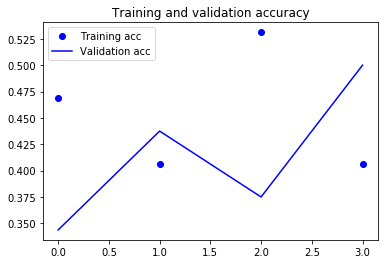

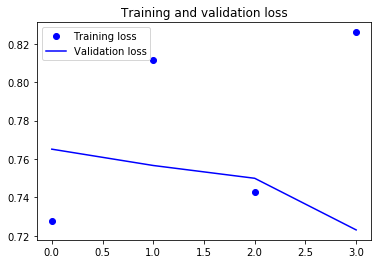

In [11]:
#checking the result of the model.

acc = history.history['acc']
print('Accuracy:',acc)
val_acc = history.history['val_acc']

loss = history.history['loss']
print('Loss:',loss)
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
#To fine tune the model, unfroze last block of the pretrained model 
# since last block contains more complicated data
#that does not apply to most of the images unlike lower level that has edges 
# or other simpler data that can be reused for other classifications
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    elif layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
#train the model again with partially unfrozen model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-8),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])


# steps_epoch = int(tf.ceil(len(img_paths)/batch_size).numpy())
# steps_epoch = 2

# num_epochs = steps_epoch*2
# num_epochs = 1


history = model.fit(
    train_ds,
    steps_per_epoch=steps_epoch,
    epochs=num_epochs,
    validation_data=val_ds,
    validation_steps=steps_epoch)

Epoch 1/4
2/2 [==============================] - 37s 18s/step - loss: 0.8027 - acc: 0.4688 - val_loss: 0.7351 - val_acc: 0.4531
Epoch 2/4
2/2 [==============================] - 35s 17s/step - loss: 0.8200 - acc: 0.4375 - val_loss: 0.7426 - val_acc: 0.4062
Epoch 3/4
2/2 [==============================] - 38s 19s/step - loss: 0.8513 - acc: 0.4062 - val_loss: 0.7510 - val_acc: 0.3750
Epoch 4/4
2/2 [==============================] - 45s 22s/step - loss: 0.7187 - acc: 0.5312 - val_loss: 0.7279 - val_acc: 0.4531


Accuracy: [0.46875, 0.4375, 0.40625, 0.53125]
Loss: [0.8027015924453735, 0.8199557960033417, 0.8512827157974243, 0.7187453508377075]


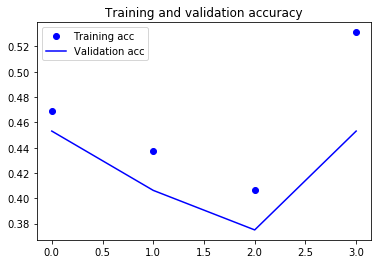

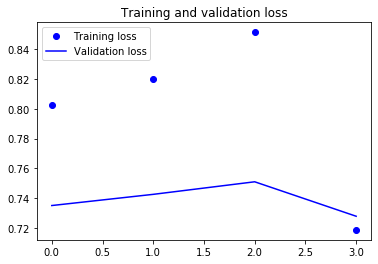

In [14]:
#checking the result of the model.

acc = history.history['acc']
print('Accuracy:',acc)
val_acc = history.history['val_acc']

loss = history.history['loss']
print('Loss:',loss)
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
test_loss, test_acc = model.evaluate(
    test_ds,
    steps=steps_epoch)

2/2 [==============================] - 12s 6s/step - loss: 0.6686 - acc: 0.5625


### Save model

In [ ]:
#saving model for future use
filename = 'model_VGG_finetuned.h5'
model.save(filename)
print('Saved: %s' % filename)